## Exploring the data

In [233]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv")

# the dataframe is small enough to be able to display it entirely
df[:]

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


First noticeable thing is that the states column is named city. 
So let's fix that 

In [234]:
df.rename(columns={'City': 'State'}, inplace=True)

df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Now we can have a look at the statistical properties of each column

In [235]:
stats = df.describe()

# let's reduce and transpose to improve readability
important_stats = stats.loc[["mean","std","min","max"]].transpose()
important_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


The assault feature catches the eye immediately as its mean is roughly double the sum of all the other means in the dataset, and it also has the biggest standard deviation.  
The PCA of unstandardised data will be very skewed towards this feature.  


In [236]:
# check for null values
df.isnull().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [237]:
# and the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


It does make sense to have integers and floats as 3 of the features are an average of arrests per 100.000 residents, and the urban population is a percentage.  

The data set is ideal in completeness and accuracy of the data.  

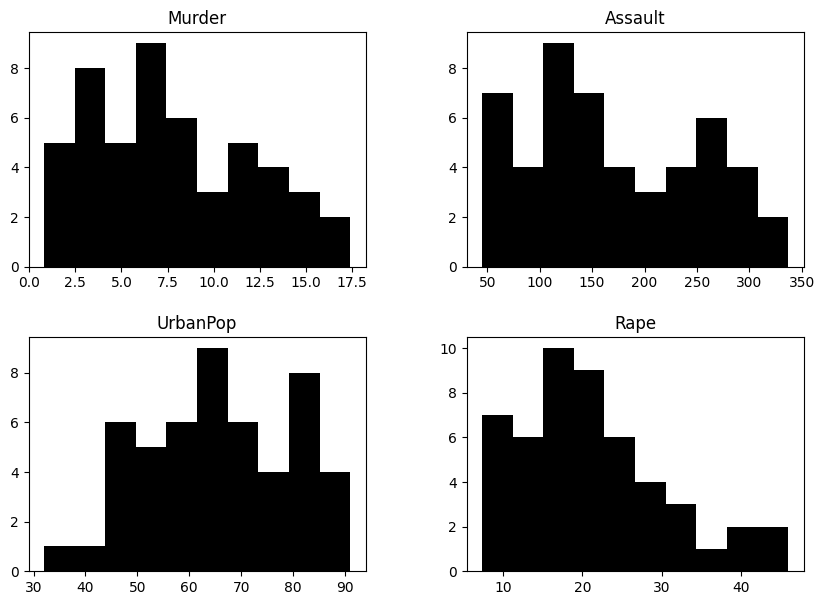

In [238]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(10, 7)) #This can also be done for each column individually by calling hist on that column

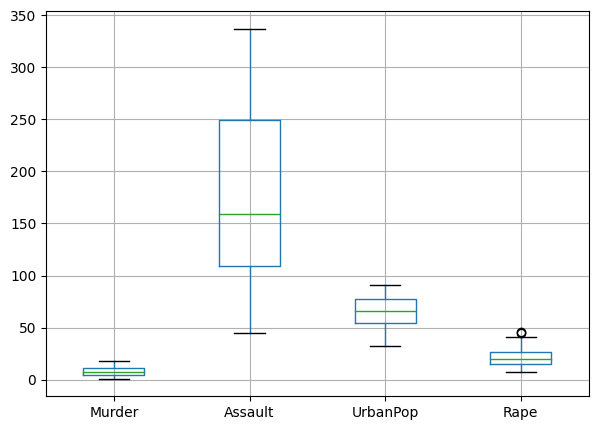

In [239]:
box_plots = df.boxplot(figsize=(7, 5))

From the boxplots we can see how the 'heaviest' feature(Assault) is also the most skewed. A further confirmation that standardisation is necessary. 

## Correlation Analysis

<AxesSubplot: >

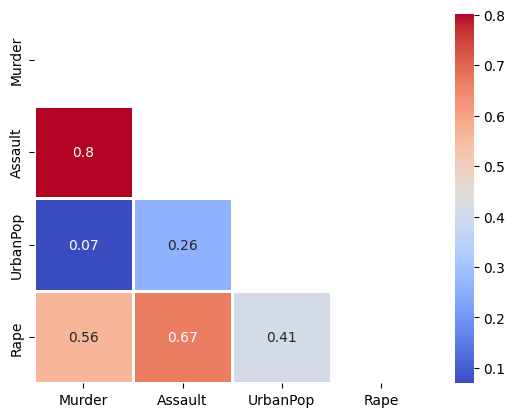

In [240]:

# let's calculate the correlation between features
corr_df = df.drop(columns='State').corr()


# and visualize them with a heatmap
dropSelf = np.zeros_like(corr_df)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr_df, cmap="coolwarm", annot=True, mask=dropSelf, linewidths=2)


Out of a total of 4 features, 3 have a high positive correlation (> 50%); assault, murder and rape are all different forms of violence and aggregation. Rape is a specific form of assault and murder is just the worst outcome that an assault can have.

The urban population vs murder square is in a dark blue and that can be deceiving as most heatmaps use blue for negative correlations; in this case it is dark blue just because happens to be the lowest measured correlation, but its value is still positive and very close to 0.

Overall, this makes the data a good candidate for PCA. PCA will be able to further reduce the number of variables, given that they encode similar types of differences.

## PCA

In [241]:
# prepare the independent variables for PCA
X = df.drop(["State"],axis=1).values.squeeze()

pca = PCA()

# apply the algorithm to the data
X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


### Importance of components

In [242]:
# standard deviation 
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

# Proportion of variance explained
explained_var = pca.explained_variance_ratio_
print(f"Proportion of Variance Explained: {explained_var}")

# cumulative proportion
cumul_prop = np.cumsum(pca.explained_variance_)
print(f"Cumulative Proportion: {cumul_prop}")

Standard deviation: [83.73 14.21  6.49  2.48]
Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]
Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


PCA has split the dataset into four main components. 
The first component has still a very big standard deviation, which is one of the reason why it accounts for more than 96% of the variance explained in the dataset. 
I'm expecting it to incorporate most of the 'Assault' feature. 

The first two components account for more than 99% of the variance in the dataset. 

In [243]:
# the biplot function as shown in the assignment task

def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

In [244]:
# values sorted by highest urban population percentage
df.sort_values(by='UrbanPop', ascending=False)

,State,Murder,Assault,UrbanPop,Rape
4,California,9.0,276,91,40.6
29,New Jersey,7.4,159,89,18.8
38,Rhode Island,3.4,174,87,8.3
31,New York,11.1,254,86,26.1
20,Massachusetts,4.4,149,85,16.3
10,Hawaii,5.3,46,83,20.2
12,Illinois,10.4,249,83,24.0
27,Nevada,12.2,252,81,46.0
42,Texas,12.7,201,80,25.5
2,Arizona,8.1,294,80,31.0


In [245]:
#values sorted by highest assault rate
df.sort_values(by='Assault', ascending=False)

,State,Murder,Assault,UrbanPop,Rape
32,North Carolina,13.0,337,45,16.1
8,Florida,15.4,335,80,31.9
19,Maryland,11.3,300,67,27.8
2,Arizona,8.1,294,80,31.0
30,New Mexico,11.4,285,70,32.1
39,South Carolina,14.4,279,48,22.5
4,California,9.0,276,91,40.6
1,Alaska,10.0,263,48,44.5
23,Mississippi,16.1,259,44,17.1
21,Michigan,12.1,255,74,35.1


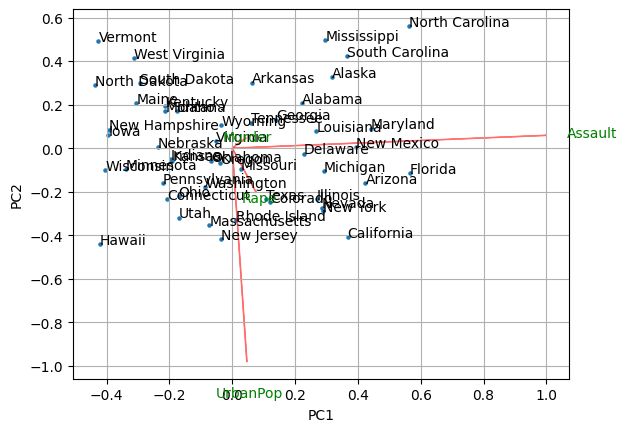

In [246]:
states = df['State']
labels =corr_df.columns


biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

This graph accounts for more than 99% of the variance in the dataset. PC1 is the 'violence' variable, the right side represents states with the most number of assaults, 
while PC2 (which accounts for roughly 3 % of the variance) incorporates the percentage of 'urban population', with the bottom of the list having the highest urbanized states(data is from 1973) and the top the lowest. 

We can also visualize that the urban population percentage has no effect on the ammount of total violence and aggression. 

Finally, because of the high internal correlation in PC1, all data is grouped in a single cluster. 

Let's find the best standardisation method and apply it to allow all features do be more descriptive, as at the moment 'Assault' is overshadowing Rape and Murder which, altough a lot less frequent, are far worse in gravity and it's important to be able to account for that as that's the category that requires a more urgent intervention, and most resources need to allocated to try to prevent these worst case scenarios first. 


### Standardised data


In [247]:
# standardised data
X_std = StandardScaler().fit_transform(X)

# fit PCA to the standardised data
std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

In [248]:
# values sorted by highest murder rate
df.sort_values(by='Murder', ascending=False)

,State,Murder,Assault,UrbanPop,Rape
9,Georgia,17.4,211,60,25.8
23,Mississippi,16.1,259,44,17.1
8,Florida,15.4,335,80,31.9
17,Louisiana,15.4,249,66,22.2
39,South Carolina,14.4,279,48,22.5
0,Alabama,13.2,236,58,21.2
41,Tennessee,13.2,188,59,26.9
32,North Carolina,13.0,337,45,16.1
42,Texas,12.7,201,80,25.5
27,Nevada,12.2,252,81,46.0


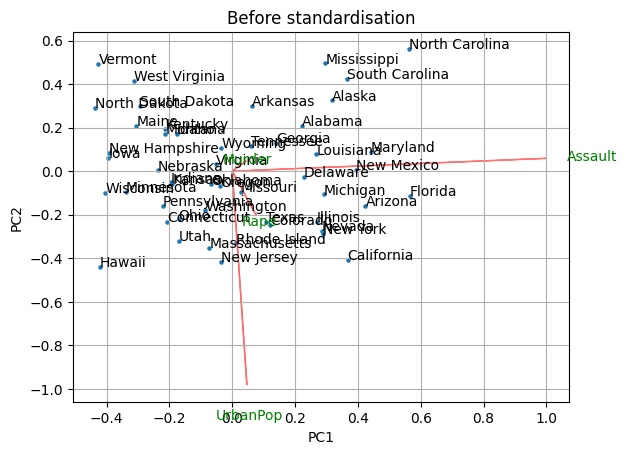

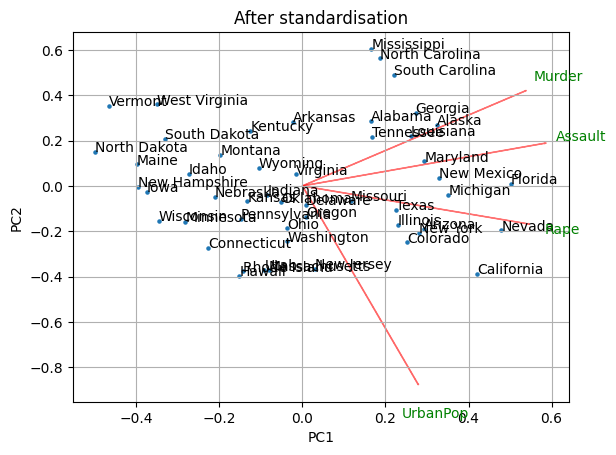

In [249]:

biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.title('Before standardisation')
plt.show()

biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.title('After standardisation')
plt.show()

We can now see that all factors have a bigger impact, some states have moved and some clusters are starting to form. 

Mississipi, North Carolina and South Carolina have some of the lowest urban population and have been pushed further up and to the right by the 'Murder' feature. 

Tennesse, Georgia, Louisiana and Alabama have moved further away from the centre closer to the higher-right corner, given that the high 'Murder' rate weighs more in the equation. 

MAryland, New MExico, Florida and Michigan are now further right in a cluster which is  high in 'Assault' and 'Rape'. 
Texas, Illinois, New YOrk and Colorado have similar features but they are more urbanized, therefore lower. 

California is still the bottom right outlier, but the high rate of 'Rape' pushed it much further to the right than it was before. 

Vermont is still the top left outlier which, given the topic, is a very good position to be in; the very low murder and assault together with a fairly low rape has pushed it further to the left, making it one of the most peaceful states in a fairly close cluster with West Virginia, South Dakota and North Dakota. 

Hawaii is no longer the bottom left outlier, as its high rate of rapes pushes it further to the right and closer to the centre.

We can see 2 bigger clusters forming, one on the right with the highest aggressive states and the big one on the left with the more peaceful countries. 

In the most aggressive cluster we can notice some smaller clusters, differentiated by the urbanisation rate and mostly whether they are higher in Murder or Rape. Weighing in properly these two features has created a much clearer picture of the distribution and nature of the aggression and violence in each state. 

Text(0.5, 1.0, 'Cumulative Explained Variance')

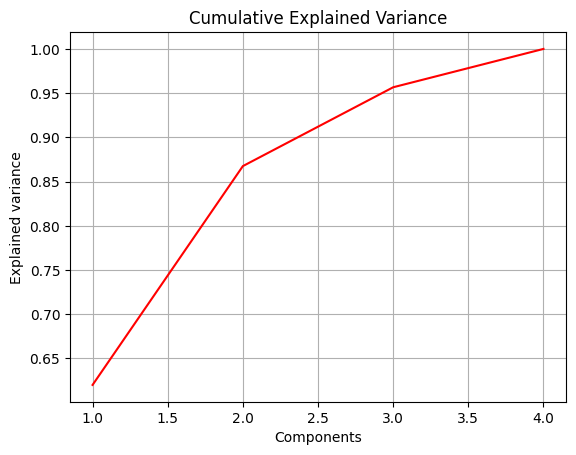

In [250]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.grid()
plt.title("Cumulative Explained Variance")

Now the first two PCA features only account for roughly 87% of the variance instead of more than 99%. 
It takes 3 features to get up to 96% and all 4 to pass 99%.   

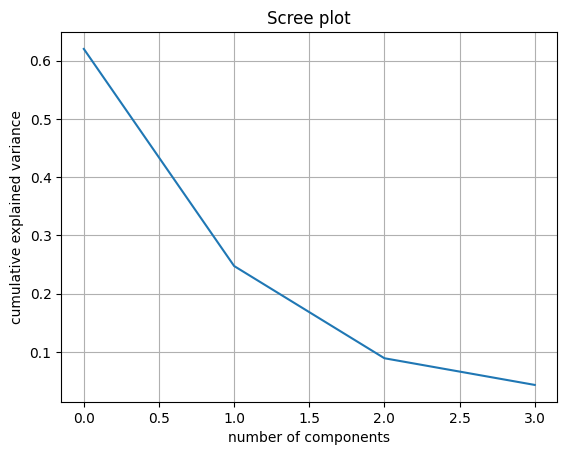

In [251]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.title("Scree plot")
plt.show()

The first two features are still dominant(surely more balanced) and explain almost 90% of the variance. 
I'm not entirely happy to use them to perform cluster analysis, as adding a 3rd feature covers about 5% more. 

This dataset has a high internal correlation, but given the already small amount of variables available, we can only reduce it by 1 without a considerable data loss. 

In [252]:
# we'll use the first 3 principal variables
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
0,0.985566,1.133392,-0.444269
1,1.950138,1.073213,2.040003
2,1.763164,-0.745957,0.054781
3,-0.141420,1.119797,0.114574
4,2.523980,-1.542934,0.598557


## Hierarchical clustering

We're going to create a hierarchical clustering model and plot the dendrograms for the 3 main methods to see which one gives the most diverse and balanced clusters.

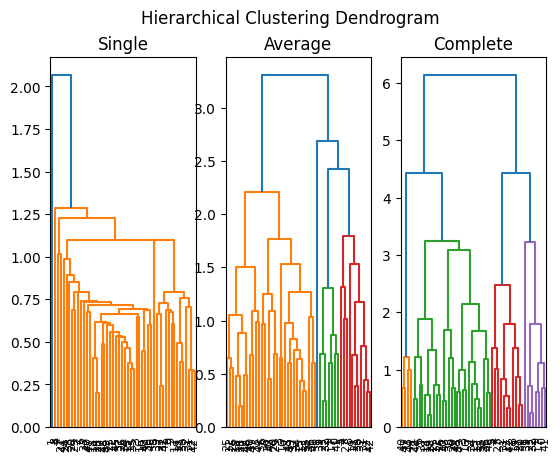

In [253]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) 
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

The complete method seems far superior to the other two, let's take a closer look at the dendrogram:

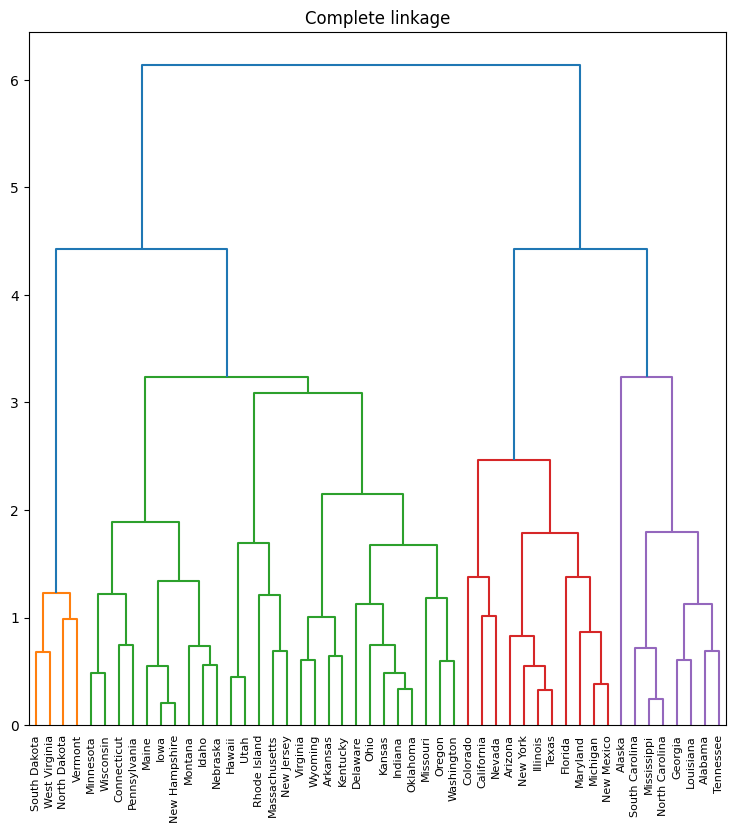

In [254]:
pca_df.set_index(df['State'], inplace=True)
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1, 1, 1)
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

The first orange cluster identified is the one with the most peaceful countries, which have been further rewarded by the standardised model and the complete linkage method. 

The green cluster is formed by the vast majority of the states and is the middle-group cluster of states that don't stand oot for any one of the violence fetures measured in the dataset. 

The red and the violet clusters compose the right high in aggressivity states, which have been identified in the standardised byplot. 

The red cluster states are linked by a higher urbanisation percentage and they tend to be higher in rape, while the purple cluster states have a lower urban population and they are higher in murder.

It's interesting to see that the model is rewarding the most peaceful countries more than for example identifing the top right cluster of three countries which stood out for their low urbanisation rates. This testifies the fact the the total aggressiveness factor is still the most descriptive feature for variance. 

### K-means clustering

K-means is a very popular clustering partitioning algorithm that is fast and efficient and scales well for large datasets. It is an iterative process, so observations can switch between clusters while the algorithm runs until it converges at a local optimum. This method is not robust when it comes to noise data and outliers and is not suitable for clusters with non-convex shapes. Another drawback with K-means is the necessity of specifying K in advance.

Luckily, the shape of clusters in our analysis is likely to be regular based on the PCA biplot. I will set K to 4.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


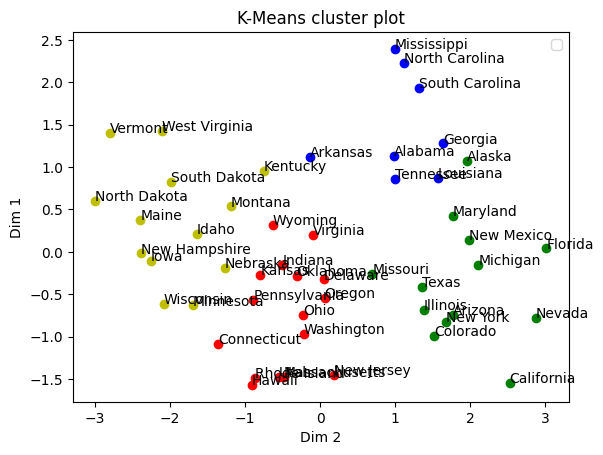

In [255]:

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_init='auto', n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

Seems that the KNN model has split the graph in 4 clusters based on aggressivity levels, murder or rape rates and urbanisation. 

So we have a lowly urbanised and lowly aggressive cluster in yellow.

A highly-urbanised and lowly aggressive cluster in red, with a predominance of rape as the second most committed crime after asssault. 

A lowly-urbanised and highly aggressive cluster in blue, with a predominance of murder over rape.  

And a highly-urbanised and highly aggressive cluster in green, that maxes out many aggressivity factors, and particularly rape. 



Essentially the big green middle cluster in the hierachical model has been now split in two based on urbanisation levels and whether the second most popular crime is murder or rape. 

There is a blue cluster that resembles a lot the purple hierarchical cluster  for the ecception of Alaska, which is the green cluster due to the high rape percentages and it has been replaced by Arkansas, which used to be in the main central green cluster, but given the higher overall aggressivity level it's been penalised by the KNN and moved into the blue cluster. 